# Solution of the atom within LDA

In this excercise we will solve the multielectron atom in LDA approximation.

We will test it on He and oxygen by computing the total energy and charge density.

We will plot charge density and compute the total energy, which will be compared to the reference data at NIST database:
https://www.nist.gov/pml/atomic-reference-data-electronic-structure-calculations/atomic-reference-data-electronic-7




We want to solve the Schroedinger equation for an atom with nucleous charge Z. We will approximate electron-electron interaction with an effective potential, which is computed by so-called ”local density approximation” (LDA). In this theory, the classical (Hartree) potential is treated exactly, while the rest of the interaction is ”approximated” by so called *local exchange-correlation functional*. We will not go into details of this functional, we will just use it here.




The Schroedinger equation we are solving is
\begin{eqnarray}
(-\frac{\hbar^2}{2m}\nabla^2-\frac{Z e^2}{4\pi\varepsilon_0 r} + V_H(r) + V_{xc}(r))\psi(\vec{r})=E \psi(\vec{r})
\end{eqnarray}

The first two terms are appearing in Hydrogen problem, and we already coded them. The Hartree is the electrostatic potential, and the exchange-correlation potential has an approximate form, which depends only the charge density of the system. We will use the module `excor.py`, where the function $V_{xc}(\rho)$ is tabulated. We will use it as $V_{xc}(r)== V_{xc}(\rho(r))$, corresponding to the local density approximation.

First we take the code from the Hydrogen project and repeat.

In [1]:
from scipy import *
from scipy import integrate
from scipy import optimize
from numpy import *
from pylab import *
from numba import jit

In [2]:
@jit(nopython=True)
def Numerov(f, x0, dx, dh):
    """ Given precumputed function f(x) solved the differential equation
        x''(t) = f(t) x(t)
        input: x0 = x(t=0), and dx = dx/dt(t=0)
    """
    x = zeros(len(f))
    x[0] = x0
    x[1] = x0 + dh*dx
    h2 = dh**2
    h12 = h2/12.
    w0 = x0*(1-h12*f[0])
    w1 = x[1]*(1-h12*f[1])
    xi = x[1]
    fi = f[1]
    for i in range(2,len(f)):
        w2 = 2*w1-w0 + h2*fi*xi
        fi = f[i]
        xi = w2/(1-h12*fi)
        x[i]=xi
        (w0,w1) = (w1,w2)
    return x

@jit(nopython=True)
def fShrod(En,l,R):
    return l*(l+1.)/R**2 - 2./R - En

def ComputeSchrod(En, R, l):
    f = fShrod(En,l,R[::-1])
    ur = Numerov(f, 0.0, -1e-7, -R[1]+R[0])[::-1]
    norm = integrate.simps(ur**2, x=R)
    return ur/sqrt(abs(norm))
    
def Shoot(En, R, l):
    ur = ComputeSchrod(En, R, l)
    ur = ur/R**l  # expecting urn \propto R
    f0,f1 = ur[0],ur[1]
    f_at_0 = f0 + (f1-f0)*(0-R[0])/(R[1]-R[0]) # extrapolation to zero
    return f_at_0

def FindBoundStates(R, l, nmax, Esearch):
    n=0
    Ebnd=[]
    u0 = Shoot(Esearch[0],R,l)
    for i in range(1,len(Esearch)):
        u1 = Shoot(Esearch[i],R,l)
        if u0*u1 < 0:
            #print 'Sign change at', Esearch[i-1], Esearch[i]
            Ebound = optimize.brentq(Shoot,Esearch[i-1],Esearch[i],xtol=1e-15,args=(R,l))
            Ebnd.append( (l,Ebound) )
            if len(Ebnd)>nmax: break
            n += 1
            print('Found bound state at E=%14.9f' % Ebound)
        u0 = u1
    return Ebnd 

def cmpKey(x):
    return x[1]*1000 + x[0]  # energy has large wait, but degenerate energy states are sorted by l

def ChargeDensity(Bnd,R,Z):
    rho = zeros(len(R))
    N=0.
    for (l,En) in Bnd:
        ur = ComputeSchrod(En, R, l)
        dN = 2*(2*l+1)
        if N+dN <= Z:
            ferm = 1.
        else:
            ferm = (Z-N)/float(dN)
        drho = ur**2 * ferm * dN/(4*pi*R**2)
        rho += drho
        N += dN
        print('adding state', (l,En), 'with fermi=', ferm)
        if  N>=Z: break
    return rho

Found bound state at E=  -0.999922109
Found bound state at E=  -0.249990190
Found bound state at E=  -0.111108201
Found bound state at E=  -0.062498772
Found bound state at E=  -0.039999314
Found bound state at E=  -0.250000016
Found bound state at E=  -0.111111117
Found bound state at E=  -0.062500003
Found bound state at E=  -0.039999959
Found bound state at E=  -0.111111111
Found bound state at E=  -0.062500000
Found bound state at E=  -0.039999977
Found bound state at E=  -0.062500000
Found bound state at E=  -0.039999992
adding state (0, -0.9999221089559623) with fermi= 1.0
adding state (0, -0.24999019020653063) with fermi= 1.0
adding state (1, -0.25000001561170354) with fermi= 1.0
adding state (0, -0.11110820082299863) with fermi= 1.0
adding state (1, -0.11111111678092336) with fermi= 1.0
adding state (2, -0.11111111114690274) with fermi= 1.0


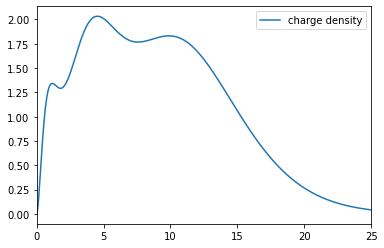

In [3]:
%matplotlib inline

Esearch = -1.2/arange(1,20,0.2)**2
R = linspace(1e-8,100,2000)

Z=28
nmax = 5
Bnd=[]
for l in range(nmax-1):
    Bnd += FindBoundStates(R,l,nmax-l,Esearch)
Bnd = sorted(Bnd, key=cmpKey)

z = 28. # like Ni atom

rho = ChargeDensity(Bnd,R,Z)
        
plot(R, rho*(4*pi*R**2), label='charge density')
xlim([0,25])
legend(loc='best')
show()

## Hartree term

The Hartree term is treated exactly in this approximation. 

It describes the electrostatic
interaction of one electron with the cloud of all electrons (including the electron itself).
Mathematically, this term is
\begin{eqnarray}
&&   \frac{1}{2}\int d\vec{r} d\vec{r}' \psi^\dagger (\vec{r})\psi^\dagger (\vec{r}')
   v_c(\vec{r}-\vec{r}') \psi(\vec{r}')\psi(\vec{r}) \rightarrow\\
&&   \int d\vec{r} \psi^\dagger(\vec{r}) \psi(\vec{r}) \int d\vec{r}'
   \langle\psi^\dagger(\vec{r}') \psi(\vec{r}')\rangle v_c(\vec{r}-\vec{r}') \equiv
   \int d\vec{r} \psi^\dagger(\vec{r}) V_{H}(\vec{r}) \psi(\vec{r})\nonumber
 \end{eqnarray}
 with
 \begin{equation}
 V_H(\vec{r}) = 2 \int d\vec{r}' \frac{\rho(\vec{r}')}{|\vec{r}-\vec{r}'|}
 \end{equation}
where $2$ is due to Rydberg units sinc $v_c = 2/r$.


For any atom, the electron density is
spherically symetric and hence $V_{H}$ depends only on radial
distance. (In solids, the hartree potential should be expanded in
spheric harmonics to sufficiently high $l$, maybe $l=6$).

### Step 1: Using $\rho(r)$ computed in previous homework, compute the Hartree potential.

This is usually achieved by solving the Poisson equation. From
clasical electrostatic we know
\begin{eqnarray}
  \nabla^2 V_{H}(\vec{r}) = -8\pi \rho(\vec{r})
\end{eqnarray}
In Hartree approximation, we have
\begin{equation}
\frac{1}{r^2}\frac{d}{dr}(r^2 \frac{d V_H}{dr})= -8\pi\rho(r)  
\end{equation}
which simplifies to
\begin{equation}
  U^{''}(r) = -8\pi r \rho(r)
\end{equation}
where $U(r) = V_{H}(r) r$.

This second order differential equation has the following boundary
conditions $U(0)=0$ and $U(\infty)=2 Z$.

The two point boundary problem does not require shooting because we
know solution to the homogenous differential equation
$U^{''}(r)=0$. The Hartree potential can be obtained from any
particular solution by
\begin{equation}
  U(r) = U_p(r) + \alpha r
\end{equation}
where $\alpha = \lim_{r\rightarrow\infty}(2 Z-U_{p}(r))/r$.


In [4]:
def FuncForHartree(y,r,rhoSpline):
    """ y = [U,U']
        dy/dr = [U', -8*pi*r*rho(r)]
    """
    return [y[1], -8*pi*r*rhoSpline(r)]

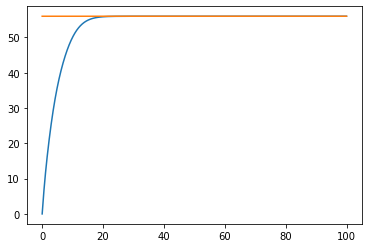

In [5]:
from scipy import interpolate

rhoSpline = interpolate.UnivariateSpline(R, rho,s=0)

U0 = integrate.odeint(FuncForHartree, [0.0,0.5], R, args=(rhoSpline,))[:,0]
alpha = (2*Z - U0[-1])/R[-1]
U0 += alpha * R

plot(R, U0)
plot(R, ones(len(R))*2*Z)
show()

## Numerov again

Poisson equation does not have the first order derivative, hence it can also be more efficiently solved by the Numerov algorithm.

We have Poisson equation, which has the form
\begin{equation}
x^{''}(t)= u(t)
\end{equation}
and the Numerov algorithm, as appropriate for the Poisson equation, is
\begin{eqnarray}
  x(h)+x(-h) = 2x(0)+h^2 u(0)+\frac{2}{4!}h^4 x^{(4)}(0)+O(h^6)
\end{eqnarray}
and the approximation for the forth order derivative is
\begin{equation}
  x^{(4)}\sim \frac{u_{i+1}-2 u_i+u_{i-1}}{h^2}
\end{equation}

Inserting the fourth order derivative into the above recursive equation (forth equation in his chapter), we
get

\begin{equation}
  x_{i+1}-2 x_i+x_{i-1}=h^2 u_i +\frac{h^2}{12}(u_{i+1}-2 u_i+u_{i-1})
\end{equation}

If we switch to a new variable $w_i=x_i-\frac{h^2}{12}u_i$
we are left with the following
equation

\begin{equation}
  w_{i+1} -2 w_i + w_{i-1} = h^2 u_i+O(h^6)
\end{equation}

The variable $x$ needs to be recomputed at each step with
$x_i=(w_i+\frac{h^2}{12}u_i)$.


In [6]:
@jit(nopython=True)
def NumerovUP(U, x0, dx, dh):
    x = zeros(len(U))
    x[0] = x0
    x[1] = dh*dh + x0
    h2 = dh*dh
    h12 = h2/12
    w0 = x[0]-h12*U[0]
    w1 = x[1]-h12*U[1]
    Ui = U[1]
    for i in range(2,len(U)):
        w2 = 2*w1 - w0 + h2*Ui
        Ui = U[i]
        xi = w2 + h12*Ui
        x[i] = xi
        w0, w1 = w1, w2
    return x

In [7]:
ux = -8*pi*R*rho
U2 = NumerovUP(ux, 0.0, 0.5, R[1]-R[0])
alpha2 = (2*Z-U2[-1])/R[-1]
U2 += alpha2 * R

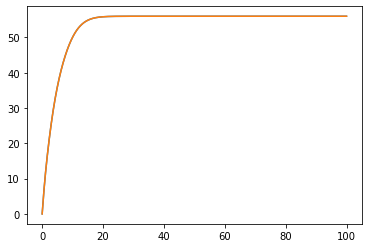

In [8]:
plot(R,U0)
plot(R,U2);

### Step1 routine HartreeU  
For generic density the following routine will work:

In [9]:
def HartreeU(R, rho, Zatom):
    """Given input charge density it returns Hartree potential in the form VH(r)*r
    """
    ux = -8*pi*R*rho
    U2 = NumerovUP(ux, 0.0, 0.5, R[1]-R[0])
    alpha2 = (2*Zatom-U2[-1])/R[-1]
    U2 += alpha2 * R
    return U2

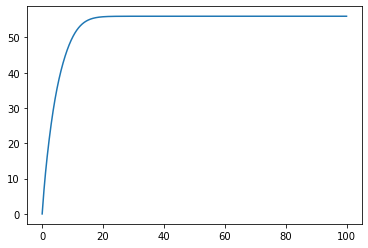

In [10]:
U2 = HartreeU(R,rho,Z)
plot(R,U2);

### Step 2 : Compute the exchange correlation potential.
   
Note that $V_{xc}(r)=V_{xc}(\rho(r))$ is unquely determined by the electron charge density $\rho(r)$. If we know $\rho$, we can instantly compute $V_{xc}$ by the module provided parametrized function.
   

Download the module `excor.py` from
http://www.physics.rutgers.edu/~haule/509/src_prog/python/homework5/
and import it in your code.


Instantiate the ExchangeCorrelation object by

`exc = ExchangeCorrelation()`

and used it, for example, by

`exc.Vx(rs(rho[i]))+exc.Vc(rs(rho[i]))`

where $r_s = ({4\pi\rho/3})^{-1/3}$.

Be careful: The energy unit in "excor.py" is Hartree and not
Rydergs. Hence, you need to multiply energy or potential by 2.



In [11]:
from excor import ExchangeCorrelation
exc = ExchangeCorrelation()

@jit(nopython=True)
def rs(rho):
    "1/rho = 4*pi*rs^3/3 => rs = (3/(4*pi*rho))**(1/3.)"
    if rho < 1e-100: return 1e100
    return pow(3/(4*pi*rho),1/3.)

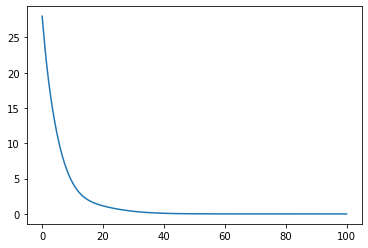

In [12]:
Vxc = [2*exc.Vc(rs(rh)) + 2*exc.Vx(rs(rh)) for rh in rho]    

Uks = U2 - 2*Z + Vxc*R

plot(R, -Uks/2);


### Step 3: Find bound states using Hartree and XC potential.

Add the Hartree potential and the exchange-correlation potential to the Schroedinger equation and find
  bound states of the atom.

The Schroedinger equation is
 \begin{equation}
   u^{''}(r) = \left(\frac{l(l+1)}{r^2}-\frac{2 Z}{r} + V_{H}(r)+V_{XC}(r)-\varepsilon\right)u(r).
 \end{equation}
or
  \begin{equation}
   u^{''}(r) = \left(\frac{l(l+1)}{r^2}+\frac{U_H - 2 Z +r V_{XC}}{r}-\varepsilon\right)u(r).
 \end{equation}

In [13]:
@jit(nopython=True)
def fShrod(En,l,R, Uks):
    return (l*(l+1.)/R +Uks)/R - En

def ComputeSchrod(En, R, l,Uks):
    f = fShrod(En,l,R[::-1],Uks[::-1])
    ur = Numerov(f, 0.0, -1e-10, R[0]-R[1])[::-1]
    norm = integrate.simps(ur**2, x=R)
    return ur/sqrt(abs(norm))

def Shoot(En, R, l, Uks):
    ur = ComputeSchrod(En, R, l,Uks)
    ur *= 1/R**l  # expecting urn \propto R
    #f0,f1 = ur[0],ur[1]
    #f_at_0 = f0 + (f1-f0)*(0-R[0])/(R[1]-R[0]) # extrapolation to zero
    #return f_at_0
    poly = polyfit(R[:4], ur[:4], deg=3)
    return polyval(poly, 0.0)

In [14]:
def FindBoundStates(R, l, nmax, Esearch, Uks):
    n=0
    Ebnd=[]
    u0 = Shoot(Esearch[0],R,l,Uks)
    for i in range(1,len(Esearch)):
        u1 = Shoot(Esearch[i],R,l,Uks)
        if u0*u1 < 0:
            Ebound = optimize.brentq(Shoot,Esearch[i-1],Esearch[i],xtol=1e-15,args=(R,l,Uks))
            Ebnd.append( (l,Ebound) )
            if len(Ebnd)>nmax: break
            n += 1
            print('Found bound state at E=%14.9f' % Ebound)
        u0 = u1
    return Ebnd 

In [15]:
#R = linspace(1e-8,10,2**13+1)
#Zatom = 8
#E0=-1.2*Zatom**2
#Eshift=0.5 # sometimes energies can be positive!!!                                                                                                                        
#Esearch = -logspace(-4,log10(-E0+Eshift),200)[::-1] + Eshift


Bnd=[]
for l in range(nmax-1):
    Bnd += FindBoundStates(R,l,nmax-l,Esearch,Uks)
    
Bnd = sorted(Bnd, key=cmpKey)

Found bound state at E=  -0.602399771
Found bound state at E=  -0.228625340
Found bound state at E=  -0.068176961
Found bound state at E=  -0.007230646
Found bound state at E=  -0.627631952
Found bound state at E=  -0.237253895
Found bound state at E=  -0.069506222
Found bound state at E=  -0.006696259
Found bound state at E=  -0.600054532
Found bound state at E=  -0.217328795
Found bound state at E=  -0.057702238
Found bound state at E=  -0.558268878
Found bound state at E=  -0.187465773



### Step 4: Compute the new electron density
by filling the lowest $Z$  eigenstatates.

In [16]:
# This is modified from Hydrogen
def ChargeDensity(bst,R,Zatom,Uks):
    rho = zeros(len(R))
    N=0.
    Ebs=0.
    for (l,En) in bst:
        ur = ComputeSchrod(En, R, l, Uks)
        dN = 2*(2*l+1)
        if N+dN <= Zatom:
            ferm = 1.
        else:
            ferm = (Zatom-N)/float(dN)
        drho = ur**2 * ferm * dN/(4*pi*R**2)
        rho += drho
        N += dN
        Ebs += En * dN * ferm
        print('adding state', (l,En/2), 'H with fermi=', ferm)
        if  N>=Zatom: break
    return (rho,Ebs)

In [17]:
rho_new, Ebs = ChargeDensity(Bnd,R,Z,Uks)

adding state (1, -0.31381597607349987) H with fermi= 1.0
adding state (0, -0.3011998855534427) H with fermi= 1.0
adding state (2, -0.3000272661852965) H with fermi= 1.0
adding state (3, -0.2791344391746787) H with fermi= 0.7142857142857143


### Step 5: Admix the new and the old density 
(50\% of the old and 50\%  of the new should work) and use the resulting density to compute the  new Hartree and exchange-correlation potential.

### Iterate Steps 1 to Step 5 until self-consistency is achieved.

For oxygen, the total energy in this implementation is : -74.47303426133809 Hartree, while NIST shows -74.473077 Hartree. This is in excellent agreement. The small loss of accuracy is mainly due to the mesh used for R.

### Evaluate the total energy

Once we see that the code converges, we can insert a new step
betwen *Step 4* and *Step 5* to compute the total energy of
the system. The total energy can be obtained by
\begin{eqnarray}
E^{LDA}_{total} &=& \sum_{i\in occupied}\int d\vec{r}
\psi_i^*(\vec{r})[-\nabla^2]\psi_i(\vec{r}) +\nonumber\\
 &+& \int d\vec{r} \rho(\vec{r}) [V_{nucleous}(\vec{r})+\epsilon_H(\vec{r}) +
   \epsilon_{XC}(\vec{r})]\nonumber\\
 &=& \sum_{i\in occupied}\int d\vec{r}
\psi_i^*(\vec{r})[-\nabla^2+V_{nucleous}+V_H+V_{XC}]\psi_i(\vec{r})
 \nonumber\\
 &+& \int d\vec{r} \rho(\vec{r}) [\epsilon_H(\vec{r})-V_H(\vec{r}) +
   \epsilon_{XC}(\vec{r})-V_{XC}(\vec{r})]\nonumber\\
 &=& \sum_{i\in occupied}\epsilon_i + \int d\vec{r} \rho(\vec{r}) [\epsilon_H(\vec{r})-V_H(\vec{r}) +
   \epsilon_{XC}(\vec{r})-V_{XC}(\vec{r})]\nonumber\\
 &=& \sum_{i\in occupied}\epsilon_i + \int d\vec{r} \rho(\vec{r}) [-\epsilon_H(\vec{r}) +
   \epsilon_{XC}(\vec{r})-V_{XC}(\vec{r})]
\end{eqnarray}
Here we used
\begin{eqnarray}
&& E_y[\rho] \equiv \int d\vec{r}\; \rho(\vec{r})\; \epsilon_y[\rho(\vec{r})]\\
&& V_y[\rho]\equiv \frac{\delta E_y[\rho]}{\delta \rho(\vec{r})}
\end{eqnarray}
where $y$ is one of $H$, $x$ or $c$. 

Hence
\begin{eqnarray}
\epsilon_H(\vec{r}) = \frac{1}{2} V_H(\vec{r})  = \frac{1}{2} \frac{U_H(\vec{r})}{r}
\end{eqnarray}
because
\begin{equation}
E_H = \int d\vec{r} d\vec{r}' \frac{\rho(\vec{r})\rho(\vec{r}')}{|\vec{r}-\vec{r}'|}
\end{equation}

The exchange-correlation energy can be obtained by a call to the
 method of \textit{ExchangeCorrelation} object.


(-1.0, 1.0)

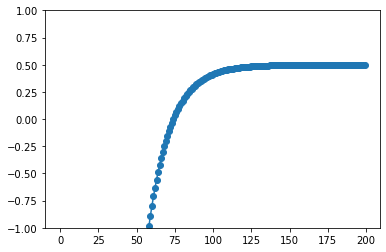

In [18]:
Zatom=8
E0=-1.2*Zatom**2
Eshift=0.5 # sometimes energies can be positive!!!                                                                                                                        
Esearch = -logspace(-4,log10(-E0+Eshift),200)[::-1] + Eshift
plot(Esearch,'o-')
ylim([-1,1])

Found bound state at E=  -1.000000000
Found bound state at E=  -0.249974229
Found bound state at E=  -0.099836095
Found bound state at E=  -0.249989213
Found bound state at E=  -0.103222840
adding state (0, -0.5000000000000026) H with fermi= 1.0
adding state (0, -0.12498711431297782) H with fermi= 1.0
adding state (1, -0.12499460664692974) H with fermi= 0.6666666666666666
Total density has weight 8.0
Itteration 0 Etot[Ry]= -16.72605139958573 Etot[Hartre]= -8.363025699792866 Diff= 16.72605139958573
Found bound state at E= -58.810318070
Found bound state at E= -11.072182717
Found bound state at E=  -2.936052943
Found bound state at E= -10.979642529
Found bound state at E=  -2.847650119
adding state (0, -29.40515903509979) H with fermi= 1.0
adding state (0, -5.536091358653621) H with fermi= 1.0
adding state (1, -5.489821264416604) H with fermi= 0.6666666666666666
Total density has weight 8.0
Itteration 1 Etot[Ry]= -224.73766490907386 Etot[Hartre]= -112.36883245453693 Diff= 208.01161350948

Found bound state at E=  -0.676810792
Found bound state at E=   0.039656201
adding state (0, -18.75829051966772) H with fermi= 1.0
adding state (0, -0.8713879791252943) H with fermi= 1.0
adding state (1, -0.3384053958563243) H with fermi= 0.6666666666666666
Total density has weight 8.0
Itteration 16 Etot[Ry]= -148.94639820419718 Etot[Hartre]= -74.47319910209859 Diff= 0.0002517056866793155
Found bound state at E= -37.516534216
Found bound state at E=  -1.742749970
Found bound state at E=  -0.007155758
Found bound state at E=  -0.676786088
Found bound state at E=   0.040125405
adding state (0, -18.758267107853968) H with fermi= 1.0
adding state (0, -0.8713749851260902) H with fermi= 1.0
adding state (1, -0.33839304389321834) H with fermi= 0.6666666666666666
Total density has weight 8.000000000000002
Itteration 17 Etot[Ry]= -148.9462743114887 Etot[Hartre]= -74.47313715574435 Diff= 0.00012389270847279477
Found bound state at E= -37.516511451
Found bound state at E=  -1.742737061
Found boun

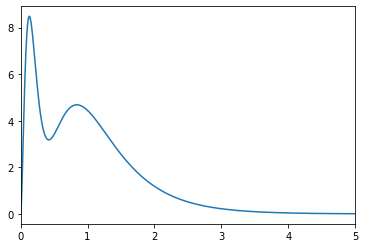

In [19]:
R = linspace(1e-8,20,2**14+1)
Zatom = 8
mixr = 0.5

E0=-1.2*Zatom**2
Eshift=0.5 # sometimes energies can be positive!!!                                                                                                                        
Esearch = -logspace(-4,log10(-E0+Eshift),200)[::-1] + Eshift
nmax = 3

exc = ExchangeCorrelation()
Uks = -2*ones(len(R))
Eold = 0
Etol = 1e-7

for itt in range(100):
    Bnd=[]
    for l in range(nmax-1):
        Bnd += FindBoundStates(R,l,nmax-l,Esearch,Uks)
    
    Bnd = sorted(Bnd, key=cmpKey)
    rho_new, Ebs = ChargeDensity(Bnd,R,Zatom,Uks)
    
    if itt==0:
        rho = rho_new
    else:
        rho = rho_new * mixr + (1-mixr)*rho_old
    rho_old = copy(rho)
    
    U2 = HartreeU(R, rho, Zatom)

    Vxc = [2*exc.Vc(rs(rh)) + 2*exc.Vx(rs(rh)) for rh in rho]   
    
    Uks = U2 - 2*Zatom + Vxc*R

    # Total energy
    ExcVxc = [2*exc.EcVc(rs(rh)) + 2*exc.ExVx(rs(rh)) for rh in rho]  
    pot = (ExcVxc*R - 0.5*U2)*R*rho*4*pi
    epot = integrate.simps(pot, x=R)
    Etot = epot + Ebs
    
    print('Total density has weight', integrate.simps(rho*(4*pi*R**2),x=R))
    #print('Total Energy=', Etot/2.)
    
    print('Itteration', itt, 'Etot[Ry]=', Etot, 'Etot[Hartre]=', Etot/2, 'Diff=', abs(Etot-Eold))

    
    if  itt>0 and abs(Etot-Eold)< Etol: break
    Eold = Etot
    
    #plot(R, U2, label='U-hartree')
    #plot(R, Vxc, label='Vxc')
    #plot(R, Uks, label='Uks')
    #show()
    
plot(R,rho*(4*pi*R**2))
xlim([0,5])
show()